# Project - Informative Bayesian Neural Network Priors for Weak Signals

**Group :** Max BOURGEAT (M2A), Sobihan SURENDRAN (M2A), Armand VIOLLE (M2A)

# 1) Introduction

Although neural networks have been effective in various applications, they suffer from certain drawbacks. One such drawback is that they don't provide uncertainty estimates for their predictions. This lack of uncertainty estimation can be problematic in situations where it is crucial to understand the level of uncertainty in the model's output. Additionally, neural networks are susceptible to overfitting, particularly when trained on a limited dataset.

To overcome these drawbacks of neural networks, Bayesian neural networks (BNNs) have emerged as a promising solution. BNNs combine neural networks with Bayesian inference, treating model parameters as random variables rather than fixed values. BNN allows the model to describe the range of possible outputs for a given input and capture uncertainty in its predictions. The challenge in Bayesian neural network lies in inferring the posterior distribution of model parameters from data, due to its high dimensionality. However, recent advancements in variational inference and Monte Carlo methods have made it possible to perform Bayesian inference in deep neural networks.



Given a dataset of inputs $X = \left\{x_1,..., x_N\right\}$ and outputs $y = \left\{y_1,..., y_N\right\}$, the goal of training a Bayesian neural network (BNN) is to compute the posterior distribution of the model parameters $p(w|X, y)$, where $w$ denotes the weights of the network. The likelihood function is represented by $p(y|x, w) = p(y|f(x; w))$, where $f(x; w)$ is the output of the BNN.

However, computing the posterior distribution $p(w|X, y)$ directly is often intractable due to the high dimensionality as discussed earlier. To overcome this, variational inference can be used to approximate the posterior distribution with a simpler distribution $q_{\phi}(w)$ by minimizing the Kullback-Leibler (KL) divergence between the true posterior distribution and the approximate distribution.

This is achieved by minimizing the following objective function:

$$ \min_{\phi} \ \text{KL}(q_{\phi}(w)\|p(w|X,y)) = \int q_{\phi}(w) \log \frac{q_{\phi}(w)}{p(w|X,y)} dw  $$

where $\phi$ denotes the parameters of the variational distribution $q_{\phi}(w)$. The optimization problem is typically solved using gradient-based methods.


The ELBO is a lower bound on the log marginal likelihood $\log p(y|X)$ and maximizing the ELBO is equivalent to minimizing the Kullback-Leibler divergence between the true posterior distribution $p(w|X,y)$ and the variational distribution $q_{\phi}(w)$.
The ELBO is given by:
$$L(\phi) = H(q_{\phi}(w)) + \mathbb{E}{q_{\phi}(w)}[\log p(y,w|X)]$$

where $H(q_{\phi}(w))$ is the entropy of the variational distribution $q_{\phi}(w)$, and $\mathbb{E}{q_{\phi}(w)}[\log p(y,w|X)]$ is the expected log-likelihood of the model parameters $w$ under the variational distribution.



The expectation hides the objective dependence on the variational parameters, which makes it hard to directly optimize. One solution to this problem is the reparameterization trick.

To apply the reparameterization trick, we reparameterize the model parameters $w$ as a deterministic function of a random variable $\xi$ with a known distribution $p(\xi)$. This transformation allows us to rewrite the ELBO as follows:

$$\mathcal{L}(\phi) = H(q_{\phi}(w)) + \mathbb{E}_{p(\xi)}[\log p(y, g(\xi; \phi)|X)] $$

where $g(\xi; \phi)$ is the deterministic function that maps $\xi$ to $w$.

Example : Suppose $\xi \sim \mathcal{N}(0,1)$, and we define $\theta = \mu + \sigma \xi $. Then, we have $\theta \sim \mathcal{N}(\mu,\sigma^2)$.

We can estimate the ELBO using Monte Carlo integration by drawing $L$ samples from the distribution $p(\xi)$, and then computing the empirical mean of the logarithm of the joint probability:

$$\widehat{\mathcal{L}}(\phi) = H(q_{\phi}(w)) + \frac{1}{L}\sum_{l=1}^{L}\log p(y, g(\xi^{(l)}; \phi)|X) $$

where $\xi^{(l)}$ is the $l$-th sample drawn from $p(\xi)$. The focus of our discussion will be on incorporating two types of prior knowledge, namely sparsity and PVE, into Bayesian Neural Networks.

# 2) Implementation

In [ ]:
!git clone https://github.com/Max9294D/InformativePrior.git

Cloning into 'InformativePrior'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 60 (delta 19), reused 31 (delta 6), pack-reused 0
Unpacking objects: 100% (60/60), 476.24 KiB | 3.45 MiB/s, done.


In [ ]:
import sys
sys.path.insert(0,'/content/InformativePrior')

## Feature selection

We ﬁrst validate the performance of the informative spike-and-slab prior proposed in the article on a feature selection task, using synthetic datasets. Instead of
a BNN, we here use linear regression, i.e., a NN without hidden layers, which enables
comparing the proposed strategy of encouraging sparsity with existing alternatives.

Consider n datapoints generated by:

$y_i = w_i + ɛ_i, ɛ_i \sim \mathcal{N}(0, σ²_ɛ), i = 1,...,n,$

where each observation $y_i$ is obtained by adding Gaussian noise with variance $σ^2$ to
the signal $w_i$. We set the number of datapoints $n$ to 400, the ﬁrst $p_0$ = 20 signals {$w_i |i = 1, . . . , 20$} equal to A (signal levels), and the rest of the signals to 0. We consider the noise levels σ = 2, and a signal levels $A$ = 10.
For each parameter setting, we generate 100 data realizations. The model
above can be considered a linear regression: $y = X ŵ^T+ ɛ$, where $X = I$ and $ŵ =
(A, . . . , A, 0, 0, . . . , 0)$ with the ﬁrst $p_0$ elements being $A$, so this is a feature selection task where the number of features and datapoints are equal. We use the mean squared
error (MSE) between the posterior mean signal w̄ and the true signal ŵ to measure the performance.

In [ ]:
from models.training import *
from models.models_lr import *
import matplotlib.pyplot as plt

In [ ]:
def data_generation(A, D, n, sigma, random_seed = 129):
    np.random.seed(random_seed);  epsilon = np.random.randn(n) * sigma;
    X = np.eye(n); beta = np.array([A] * D + [0] * (n - D)); y = beta + epsilon
    return X, y, beta

In [ ]:
D = 20; n = 400; sigma_noise = 2.0
learning_rate = 1*1e-2; batch_size = n; num_epoch = 8000;

X, y_10, beta_10 = data_generation(10, D, n, sigma_noise)
x_train = torch.tensor(X, dtype = torch.float);
y_train = torch.tensor(y_10, dtype = torch.float).view(-1,1)

For all the spike-and-slab (SS) priors, we place a diﬀuse inverse Gamma prior on $p(λ_i)$.
For the BetaSS and DeltaSS priors, we assume that $p(τ_i) = Bernoulli(p)$, and deﬁne
$p \sim Beta(2, 38)$ for BetaSS and $p = 0.05$ for DeltaSS, which both reﬂect the correct level
of sparsity. For the informative spike-and-slab, InfoSS, we use the ‘ﬂattened’ Laplace (FL) prior with $μ_{−}$ = 0, $μ_+$ = 30, and $s_m$ = 5, to encode prior knowledge
that the number of non-zero signals is (approximately) uniform on [0, 30]. We place an
$p_0$ informative half-Cauchy prior $C^+(0, τ_0²)$ on the global shrinkage scale τ with $τ_0 = \frac{p_0}{n-p_0}$ in the horseshoe (HS), to assume the same sparsity level as the other priors.

## Feature selection with BetaSS prior

In [ ]:
alpha_b = 2.0; beta_b = 38.0 # p~Beta(2, 38)
alpha_g = .001; beta_g = .001 # \lambda~Inv-Gamma(0.001, 0.001)
sigma = 1. # global scale is 1
lr_ssbg_10 = LR_BetaSS(n, sigma, alpha_b, beta_b, alpha_g, beta_g)
training_lr(lr_ssbg_10, x_train, y_train, learning_rate, batch_size, num_epoch)
beta_posterior_10 = lr_ssbg_10.Layer1.mu_beta.detach().numpy()
lambda_posterior_10 = torch.sigmoid(lr_ssbg_10.Layer1.p_logit).detach().numpy()
prediction_ssbg_10 = beta_posterior_10.reshape(-1) * lambda_posterior_10 * torch.exp(lr_ssbg_10.Layer1.mu_logsigma).detach().numpy()

EPOACH 4000: TRAIN LOSS: 2.2373; KL REG: 2394.5222.
EPOACH 8000: TRAIN LOSS: 2.3476; KL REG: 2312.5225.


## Feature selection with DeltaSS prior

In [ ]:
p = 0.05 # p=0.05
alpha_g = .001; beta_g = .001 # \lambda~Inv-Gamma(0.001, 0.001)
sigma = 1. # global scale is 1
lr_ssg_10 = LR_DeltaSS(n, sigma, p, alpha_g, beta_g)
training_lr(lr_ssg_10, x_train, y_train, learning_rate, batch_size, num_epoch)
beta_posterior_10 = lr_ssg_10.Layer1.mu_beta.detach().numpy()
lambda_posterior_10 = torch.sigmoid(lr_ssg_10.Layer1.p_logit).detach().numpy()
prediction_ssg_10 = beta_posterior_10.reshape(-1) * lambda_posterior_10 * torch.exp(lr_ssg_10.Layer1.mu_logsigma).detach().numpy()

EPOACH 4000: TRAIN LOSS: 2.3328; KL REG: 2378.8159.
EPOACH 8000: TRAIN LOSS: 2.4099; KL REG: 2314.9153.


## Feature selection with HS prior

In [ ]:
b_0 = 1.
b_g = D / (n - D) * sigma_noise; b_g = b_g ** 2 # The effective number of features is set to D
lr_hs_10 = LR_HS(n, b_g, b_0)
training_hs_lr(lr_hs_10, x_train, y_train, learning_rate, batch_size, num_epoch)
lr_hs_10.eval(); prediction_hs_10, _ = lr_hs_10(x_train)
prediction_hs_10 = prediction_hs_10.detach().numpy().reshape(-1)

EPOACH 4000: TRAIN LOSS: 1.0577; KL REG: 649.5852.
EPOACH 8000: TRAIN LOSS: 1.1950; KL REG: 632.3076.


## Feature selection with InfoSS prior

In [ ]:
k_min = 0.; k_max = 30.; tau = 5. # m~U[0,30]
alpha_g = 0.001; beta_g = 0.001 # \lambda~Inv-Gamma(0.001, 0.001)
sigma = 1. # global scale is 1
lr_infossg_10 = LR_InfoSS(n, sigma,  alpha_g, beta_g,  k_min, k_max, tau)
training_lr(lr_infossg_10, x_train, y_train, learning_rate, batch_size, num_epoch)
beta_posterior_10 = lr_infossg_10.Layer1.mu_beta.detach().numpy()
lambda_posterior_10 = torch.sigmoid(lr_infossg_10.Layer1.p_logit).detach().numpy()
prediction_infossg_10 = beta_posterior_10.reshape(-1) * lambda_posterior_10 * torch.exp(lr_infossg_10.Layer1.mu_logsigma).detach().numpy()

EPOACH 4000: TRAIN LOSS: 3.0379; KL REG: 2259.5037.
EPOACH 8000: TRAIN LOSS: 3.0712; KL REG: 2182.8650.


## Comparaison features selections

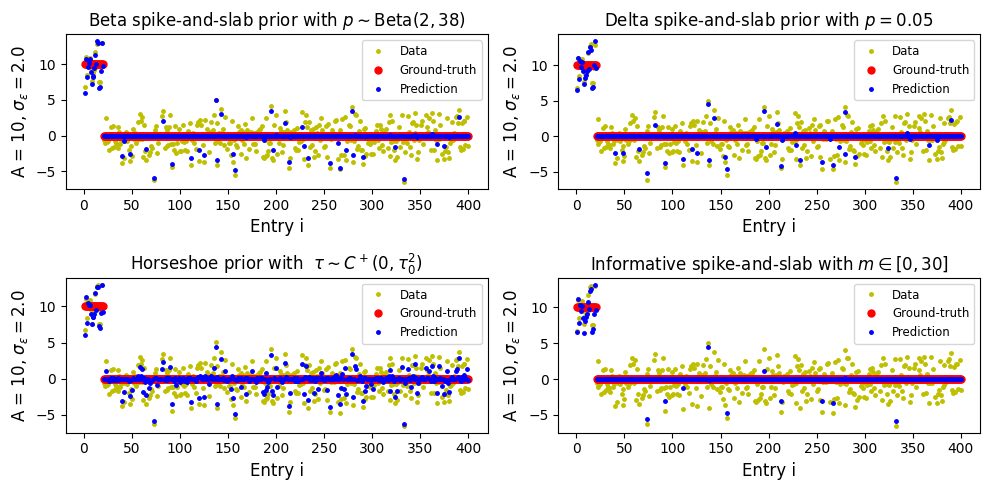

In [ ]:
x_axis = np.linspace(1, n, n);  font_size_title = 12

fig_l, axes_l = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 5))
ax_00, ax_01, ax_10, ax_11 = axes_l.flatten()

ax_00.plot(x_axis, y_10, 'y.', markersize=5)
ax_00.plot(x_axis, beta_10, 'r.', markersize=10)
ax_00.plot(x_axis, prediction_ssbg_10, 'b.', markersize=5)
ax_00.legend(['Data', 'Ground-truth', 'Prediction'], fontsize = 8.5)
ax_00.set_xlabel('Entry i', fontsize = font_size_title)
ax_00.set_ylabel(r'A = 10, $\sigma_\epsilon = 2.0$', fontsize = font_size_title)
ax_00.set_title(r'Beta spike-and-slab prior with $p \sim $Beta$(2, 38)$', fontsize = font_size_title) 

ax_01.plot(x_axis, y_10, 'y.', markersize=5)
ax_01.plot(x_axis, beta_10, 'r.', markersize=10)
ax_01.plot(x_axis, prediction_ssg_10, 'b.', markersize=5)
ax_01.legend(['Data', 'Ground-truth', 'Prediction'], fontsize = 8.5)
ax_01.set_xlabel('Entry i', fontsize = font_size_title)
ax_01.set_ylabel(r'A = 10, $\sigma_\epsilon = 2.0$', fontsize = font_size_title)
ax_01.set_title(r'Delta spike-and-slab prior with $p = 0.05$', fontsize = font_size_title) 

ax_10.plot(x_axis, y_10, 'y.', markersize=5)
ax_10.plot(x_axis, beta_10, 'r.', markersize=10)
ax_10.plot(x_axis, prediction_hs_10, 'b.', markersize=5)
ax_10.legend(['Data', 'Ground-truth', 'Prediction'], fontsize = 8.5)
ax_10.set_xlabel('Entry i', fontsize = font_size_title)
ax_10.set_ylabel(r'A = 10, $\sigma_\epsilon = 2.0$', fontsize = font_size_title)
ax_10.set_title(r'Horseshoe prior with  $\tau \sim C^+(0, \tau_0^2)$', fontsize = font_size_title) 

ax_11.plot(x_axis, y_10, 'y.', markersize=5)
ax_11.plot(x_axis, beta_10, 'r.', markersize=10)
ax_11.plot(x_axis, prediction_infossg_10, 'b.', markersize=5)
ax_11.legend(['Data', 'Ground-truth', 'Prediction'], fontsize = 8.5)
ax_11.set_xlabel('Entry i', fontsize = font_size_title)
ax_11.set_ylabel(r'A = 10, $\sigma_\epsilon = 2.0$', fontsize = font_size_title)
ax_11.set_title(r'Informative spike-and-slab with $m \in [0, 30]$', fontsize = font_size_title)  

fig_l.tight_layout()

# BNN

Setup We analyze 3 publicly available datasets: Energy eﬃciency, Concrete compressive strength, Yacht hydrodynamics, whose characteristics, the number of individuals N and
the number of features D, are given in the following table. We carry out two types of experiments:
Original datasets: we analyze the datasets as such, in which case there is no domain
knowledge about sparsity; Extended datasets: we concatenate 100 irrelevant features
with the original features and add Gaussian noise to the dependent variable such that
the PVE in the data is at most 0.2, which allows us to specify informative priors about
sparsity (the number of relevant features is at most the number of original features)
and the PVE (less than 0.2). We examine whether the performance can be improved
by encoding this extra knowledge into the prior. We use 80% of data for training and
20% for testing. We use the MSE and PVE on a test set to evaluate the performance. We repeat each experiment 10 times to obtain conﬁdence intervals.

|Dataset      |   N   |  D  |
|------------ |-------|-----|
|Energy       | 0.7k  |  8  |
|Concrete     |   1k  |  8  |
|Yacht        | 0.3k  |  3  |

In [ ]:
import os
from models.training import *
from data.data_generation import *
from models.models_nn import *
from models.stein import *
from models.pve import *
import torch.optim as optim
from data.data_generation import *
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

In [ ]:
import time

In [ ]:
def plot_empirical(samples, prior):
    # dataset
    X = samples.detach().numpy().reshape(-1)
    X_plot = np.linspace(min(X), max(X), 1000)
    num_bins = 35
    fig, ax = plt.subplots()
    # the histogram of the data
    n, bins, patches = ax.hist(X, num_bins, density=1)

    ax.set_xlabel('PVE')
    ax.set_ylabel('density')

    kde = gaussian_kde(X)
    kde_pdf = kde.evaluate(X_plot)

    prior_pdf = prior.pdf(torch.tensor(X_plot)).numpy()
    ax.plot(X_plot, kde_pdf)
    ax.plot(X_plot, prior_pdf, 'r-')
    ax.set_title('Empirical distribution of PVE')

    ax.legend(('KDE of empirical PVE', 'Prior PVE', 'Empirical PVE'))

    # Tweak spacing to prevent clipping of ylabel
    fig.tight_layout()
    plt.show()

# Energy / without noise

## 1 - Learning PVE

In [ ]:
path_data = os.getcwd() + '/InformativePrior/data/'
########### Training Hyperparameters
num_hidden_nodes = [50, 30]; alpha_s = 0.001; beta_s = 0.001
learning_rate = 2*1e-3
batch_size = 100

###########
num_random = 0; noise_level = 0.
## Load the data
x, y, x_test, y_test, num_useful, num_feature = data_generating_energy(path_data, num_random, noise_level)
k_min = 0.; k_max = num_useful; tau = np.exp(2);


In [ ]:
def learn_optimal_pve():
    alpha_prior = 5; beta_prior = 1.2; prior = BetaPrior(alpha_prior, beta_prior)  # prior pve: Beta(1.5,3)
    eta = 0.1; estimator = SteinGradientEstimator(eta)  # define the stein gradient estimator
    learning_rate = 2 * 1e-3;  M = 300 # define learning rate and batch size (M)
    num_hidden_nodes = [50, 30] # define the NN architecture
    sampler = PVESampler_InfoARD(x, M, num_hidden_nodes, k_min, k_max, tau)  # define the sampler of implicity distribution
    samples = sampler()
    plot_empirical(samples, prior)
    parameters = sampler.parameters()
    optimizer = optim.SGD(parameters, lr=learning_rate)
    num_epoch_stein = 200;
    scale = minimize_kldivergence(sampler, prior, optimizer, estimator, num_epoch_stein)
    samples = sampler()
    plot_empirical(samples, prior)
    return scale

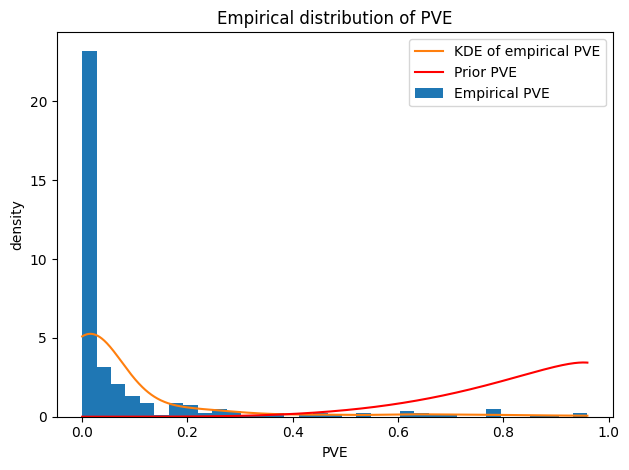

EPOCH 0: KL: 19.5240.
EPOCH 10: KL: 14.0114.
EPOCH 20: KL: 8.3775.
EPOCH 30: KL: 5.9616.
EPOCH 40: KL: 6.5591.
EPOCH 50: KL: 6.5516.
EPOCH 60: KL: 7.9787.
EPOCH 70: KL: 5.9345.
EPOCH 80: KL: 7.1923.
EPOCH 90: KL: 5.5147.
EPOCH 100: KL: 6.7052.
EPOCH 110: KL: 6.9411.
EPOCH 120: KL: 6.4232.
EPOCH 130: KL: 6.1650.
EPOCH 140: KL: 7.5289.
EPOCH 150: KL: 6.4169.
EPOCH 160: KL: 5.4847.
EPOCH 170: KL: 5.1477.
EPOCH 180: KL: 5.4436.
EPOCH 190: KL: 6.8623.


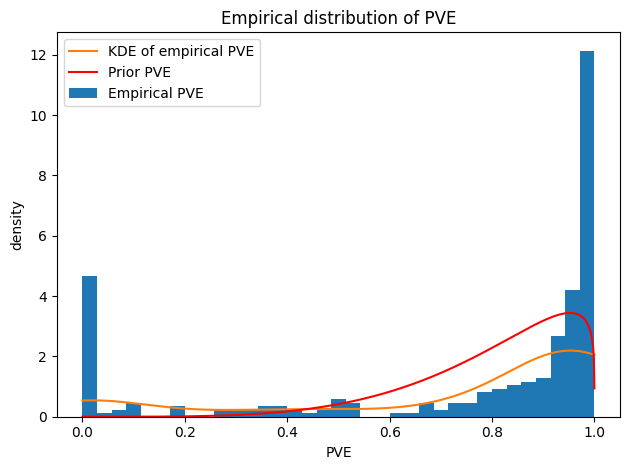

In [ ]:
start = time.time()
scale_energy_no_noisy = learn_optimal_pve()
computing_time_learning_pve_energy_no_noisy = time.time() - start

In [ ]:
print('optimal scale is ' + str(scale_energy_no_noisy))

optimal scale is [0.49123907]


## 2 - Statistical study

In [ ]:
num_simu = 10

list_test_error_hmf = []
list_test_error_ihmf = []
list_test_error_hmf_pve = []
list_test_error_ihmf_pve = []

list_time_hmf = []
list_time_ihmf = []
list_time_hmf_pve = []
list_time_ihmf_pve = []

beta_t = torch.from_numpy(scale_energy_no_noisy); alpha_t = 2.; num_epoch = 5000

for i in range(num_simu):
  print("training IHMF + PVE - simu : ", i+1," / ", num_simu)
  start = time.time()
  ihmf_pve = Info_Hier_Meanfield_PVE_NN(num_feature, num_hidden_nodes, k_min, k_max, tau, alpha_s, beta_s, alpha_t, beta_t)
  training_error_ihmf_pve, test_error_ihmf_pve = training_nn(ihmf_pve, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)
  exe_time_ihmf_pve = time.time() - start
  list_time_ihmf_pve.append(exe_time_ihmf_pve)

  print("training HMF - simu : ", i+1," / ", num_simu)
  start = time.time()
  hmf = Hier_Meanfield_NN(num_feature, num_hidden_nodes, alpha_s, beta_s, alpha_s, beta_s)
  training_error_hmf, test_error_hmf = training_nn(hmf, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)
  exe_time_hmf = time.time() - start
  list_time_hmf.append(exe_time_hmf)

  print("training IHMF - simu : ", i+1," / ", num_simu)
  start = time.time()
  ihmf = Info_Hier_Meanfield_NN(num_feature, num_hidden_nodes, k_min, k_max, tau, alpha_s, beta_s, alpha_s, beta_s)
  training_error_ihmf, test_error_ihmf = training_nn(ihmf, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)
  exe_time_ihmf = time.time() - start
  list_time_ihmf.append(exe_time_ihmf)

  print("training HMF + PVE - simu : ", i+1," / ", num_simu)
  start = time.time()
  hmf_pve = Hier_Meanfield_PVE_NN(num_feature, num_hidden_nodes, alpha_s, beta_s, alpha_t, beta_t)
  training_error_hmf_pve, test_error_hmf_pve = training_nn(hmf_pve, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)
  exe_time_hmf_pve = time.time() - start
  list_time_hmf_pve.append(exe_time_hmf_pve)

  list_test_error_hmf.append(test_error_hmf[-1])
  list_test_error_ihmf.append(test_error_ihmf[-1])
  list_test_error_hmf_pve.append(test_error_hmf_pve[-1])
  list_test_error_ihmf_pve.append(test_error_ihmf_pve[-1])
  
  print("Resultats intermédiaire  : Energy dataset sans bruit- simu : ", i," / ", num_simu-1)
  print("moyenne test error HMF", mean_list(list_test_error_hmf), " / temps d'exécution : ", mean_list(list_time_ihmf_pve))
  print("moyenne test error IHMF", mean_list(list_test_error_ihmf), " / temps d'exécution : ", mean_list(list_time_hmf))
  print("moyenne test error HMF + PVE", mean_list(list_test_error_hmf_pve), " / temps d'exécution : ", mean_list(list_time_ihmf) + computing_time_learning_pve_energy_no_noisy)
  print("moyenne test error IHMF + PVE", mean_list(list_test_error_ihmf_pve), " / temps d'exécution : ", mean_list(list_time_hmf_pve) + computing_time_learning_pve_energy_no_noisy)

print("Energy dataset sans bruit")
print("moyenne test error HMF", mean_list(list_test_error_hmf), " / temps d'exécution : ", mean_list(list_time_ihmf_pve))
print("moyenne test error IHMF", mean_list(list_test_error_ihmf), " / temps d'exécution : ", mean_list(list_time_hmf))
print("moyenne test error HMF + PVE", mean_list(list_test_error_hmf_pve), " / temps d'exécution : ", mean_list(list_time_ihmf) + computing_time_learning_pve_energy_no_noisy)
print("moyenne test error IHMF + PVE", mean_list(list_test_error_ihmf_pve), " / temps d'exécution : ", mean_list(list_time_hmf_pve) + computing_time_learning_pve_energy_no_noisy)

training IHMF + PVE - simu :  1  /  10
EPOACH 1: TRAIN LOSS: 2.2909; KL REG: 5419.4204; TEST LOSS IS: 2.25733.
EPOACH 501: TRAIN LOSS: 0.0708; KL REG: 1124.9458; TEST LOSS IS: 0.06710.
EPOACH 1001: TRAIN LOSS: 0.0595; KL REG: 484.1310; TEST LOSS IS: 0.05519.
EPOACH 1501: TRAIN LOSS: 0.0541; KL REG: 355.4530; TEST LOSS IS: 0.05512.
EPOACH 2001: TRAIN LOSS: 0.0476; KL REG: 323.0962; TEST LOSS IS: 0.05246.
EPOACH 2501: TRAIN LOSS: 0.0453; KL REG: 323.4839; TEST LOSS IS: 0.05047.
EPOACH 3001: TRAIN LOSS: 0.0436; KL REG: 321.8281; TEST LOSS IS: 0.04949.
EPOACH 3501: TRAIN LOSS: 0.0431; KL REG: 323.1751; TEST LOSS IS: 0.04937.
EPOACH 4001: TRAIN LOSS: 0.0429; KL REG: 322.7080; TEST LOSS IS: 0.04791.
EPOACH 4501: TRAIN LOSS: 0.0424; KL REG: 320.8400; TEST LOSS IS: 0.04633.
training HMF - simu :  1  /  10
EPOACH 1: TRAIN LOSS: 0.8425; KL REG: 5889.3184; TEST LOSS IS: 0.91287.
EPOACH 501: TRAIN LOSS: 0.0968; KL REG: 1409.5013; TEST LOSS IS: 0.09704.
EPOACH 1001: TRAIN LOSS: 0.0902; KL REG: 906.

# Energy / with noise


## 1 - Learning PVE

In [ ]:
path_data = os.getcwd() + '/InformativePrior/data/'
########### Training Hyperparameters
num_hidden_nodes = [50, 30]; alpha_s = 0.001; beta_s = 0.001
learning_rate = 2*1e-3
batch_size = 100
###########
num_random = 100; noise_level = 0.8
## Load the data
x, y, x_test, y_test, num_useful, num_feature = data_generating_energy(path_data, num_random, noise_level)
k_min = 0.; k_max = num_useful; tau = np.exp(2);


In [ ]:
def learn_optimal_pve():
    alpha_prior = 1.5; beta_prior = 3; prior = BetaPrior(alpha_prior, beta_prior)  # prior pve: Beta(1.5,3)
    eta = 0.1; estimator = SteinGradientEstimator(eta)  # define the stein gradient estimator
    learning_rate = 2 * 1e-3;  M = 300 # define learning rate and batch size (M)
    num_hidden_nodes = [50, 30] # define the NN architecture
    sampler = PVESampler_InfoARD(x, M, num_hidden_nodes, k_min, k_max, tau)  # define the sampler of implicity distribution
    samples = sampler()
    plot_empirical(samples, prior)
    parameters = sampler.parameters()
    optimizer = optim.SGD(parameters, lr=learning_rate)
    num_epoch_stein = 200;
    scale = minimize_kldivergence(sampler, prior, optimizer, estimator, num_epoch_stein)
    samples = sampler()
    plot_empirical(samples, prior)
    return scale

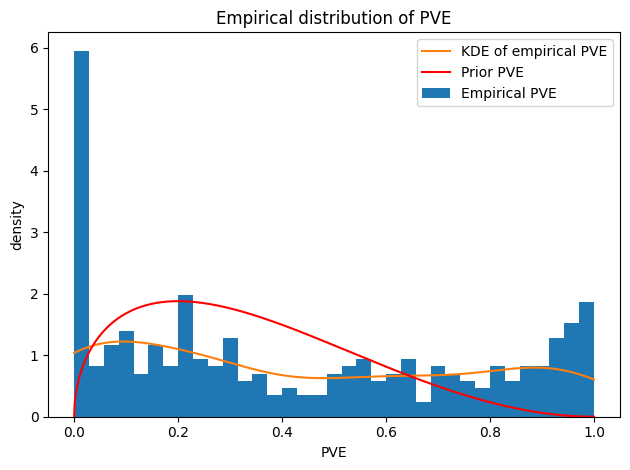

EPOCH 0: KL: 0.8920.
EPOCH 10: KL: 0.4601.
EPOCH 20: KL: 0.5852.
EPOCH 30: KL: 0.5115.
EPOCH 40: KL: 0.3698.
EPOCH 50: KL: 0.1744.
EPOCH 60: KL: 0.2591.
EPOCH 70: KL: 0.0746.
EPOCH 80: KL: 0.1752.
EPOCH 90: KL: 0.3015.
EPOCH 100: KL: -0.0020.
EPOCH 110: KL: 0.0370.
EPOCH 120: KL: 0.3204.
EPOCH 130: KL: 0.1586.
EPOCH 140: KL: 0.1089.
EPOCH 150: KL: 0.1321.
EPOCH 160: KL: 0.0262.
EPOCH 170: KL: 0.1470.
EPOCH 180: KL: -0.0643.
EPOCH 190: KL: 0.0949.


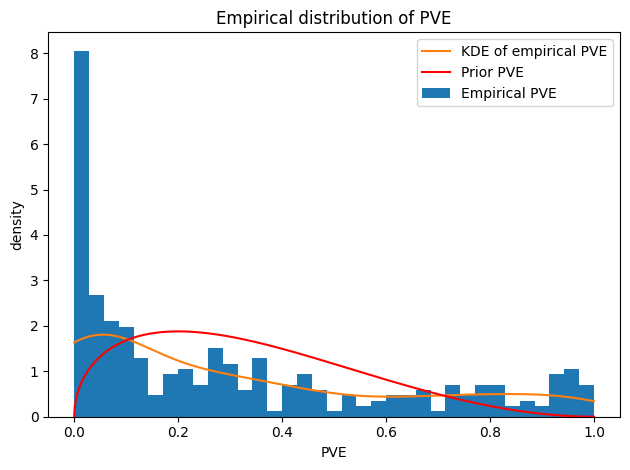

In [ ]:
start = time.time()
scale_energy_noisy = learn_optimal_pve()
computing_time_learning_pve_energy_noisy = time.time() - start

In [ ]:
print('optimal scale is ' + str(scale_energy_noisy))

optimal scale is [0.20275274]


## 2 - Statistical Study

In [ ]:
num_simu = 10

list_test_error_hmf = []
list_test_error_ihmf = []
list_test_error_hmf_pve = []
list_test_error_ihmf_pve = []

list_time_hmf = []
list_time_ihmf = []
list_time_hmf_pve = []
list_time_ihmf_pve = []

beta_t = torch.from_numpy(scale_energy_noisy); alpha_t = 2.; num_epoch = 5000

for i in range(num_simu):
  print("training IHMF + PVE - simu : ", i+1," / ", num_simu)
  start = time.time()
  ihmf_pve = Info_Hier_Meanfield_PVE_NN(num_feature, num_hidden_nodes, k_min, k_max, tau, alpha_s, beta_s, alpha_t, beta_t)
  training_error_ihmf_pve, test_error_ihmf_pve = training_nn(ihmf_pve, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)
  exe_time_ihmf_pve = time.time() - start
  list_time_ihmf_pve.append(exe_time_ihmf_pve)

  print("training HMF - simu : ", i+1," / ", num_simu)
  start = time.time()
  hmf = Hier_Meanfield_NN(num_feature, num_hidden_nodes, alpha_s, beta_s, alpha_s, beta_s)
  training_error_hmf, test_error_hmf = training_nn(hmf, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)
  exe_time_hmf = time.time() - start
  list_time_hmf.append(exe_time_hmf)

  print("training IHMF - simu : ", i+1," / ", num_simu)
  start = time.time()
  ihmf = Info_Hier_Meanfield_NN(num_feature, num_hidden_nodes, k_min, k_max, tau, alpha_s, beta_s, alpha_s, beta_s)
  training_error_ihmf, test_error_ihmf = training_nn(ihmf, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)
  exe_time_ihmf = time.time() - start
  list_time_ihmf.append(exe_time_ihmf)

  print("training HMF + PVE - simu : ", i+1," / ", num_simu)
  start = time.time()
  hmf_pve = Hier_Meanfield_PVE_NN(num_feature, num_hidden_nodes, alpha_s, beta_s, alpha_t, beta_t)
  training_error_hmf_pve, test_error_hmf_pve = training_nn(hmf_pve, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)
  exe_time_hmf_pve = time.time() - start
  list_time_hmf_pve.append(exe_time_hmf_pve)

  list_test_error_hmf.append(test_error_hmf[-1])
  list_test_error_ihmf.append(test_error_ihmf[-1])
  list_test_error_hmf_pve.append(test_error_hmf_pve[-1])
  list_test_error_ihmf_pve.append(test_error_ihmf_pve[-1])

  print("Resultats intermédiaire  : Energy dataset avec bruit- simu : ", i+1," / ", num_simu)
  print("moyenne test error HMF", mean_list(list_test_error_hmf), " / temps d'exécution : ", mean_list(list_time_ihmf_pve))
  print("moyenne test error IHMF", mean_list(list_test_error_ihmf), " / temps d'exécution : ", mean_list(list_time_hmf))
  print("moyenne test error HMF + PVE", mean_list(list_test_error_hmf_pve), " / temps d'exécution : ", mean_list(list_time_ihmf) + computing_time_learning_pve_energy_noisy)
  print("moyenne test error IHMF + PVE", mean_list(list_test_error_ihmf_pve), " / temps d'exécution : ", mean_list(list_time_hmf_pve) + computing_time_learning_pve_energy_noisy)

print("Resultats finaux : Energy dataset avec bruit")
print("moyenne test error HMF", mean_list(list_test_error_hmf), " / temps d'exécution : ", mean_list(list_time_ihmf_pve))
print("moyenne test error IHMF", mean_list(list_test_error_ihmf), " / temps d'exécution : ", mean_list(list_time_hmf))
print("moyenne test error HMF + PVE", mean_list(list_test_error_hmf_pve), " / temps d'exécution : ", mean_list(list_time_ihmf) + computing_time_learning_pve_energy_noisy)
print("moyenne test error IHMF + PVE", mean_list(list_test_error_ihmf_pve), " / temps d'exécution : ", mean_list(list_time_hmf_pve) + computing_time_learning_pve_energy_noisy)

training IHMF + PVE - simu :  1  /  10
EPOACH 1: TRAIN LOSS: 1.4761; KL REG: 19364.7129; TEST LOSS IS: 1.61374.
EPOACH 501: TRAIN LOSS: 0.8374; KL REG: 2385.0940; TEST LOSS IS: 0.88864.
EPOACH 1001: TRAIN LOSS: 0.9018; KL REG: 380.7964; TEST LOSS IS: 0.87002.
EPOACH 1501: TRAIN LOSS: 0.8987; KL REG: 166.6641; TEST LOSS IS: 0.86796.
EPOACH 2001: TRAIN LOSS: 0.8930; KL REG: 85.5714; TEST LOSS IS: 0.86624.
EPOACH 2501: TRAIN LOSS: 0.8826; KL REG: 90.3796; TEST LOSS IS: 0.86596.
EPOACH 3001: TRAIN LOSS: 0.8775; KL REG: 81.8431; TEST LOSS IS: 0.86881.
EPOACH 3501: TRAIN LOSS: 0.8794; KL REG: 76.7868; TEST LOSS IS: 0.87016.
EPOACH 4001: TRAIN LOSS: 0.8777; KL REG: 85.5627; TEST LOSS IS: 0.86678.
EPOACH 4501: TRAIN LOSS: 0.8754; KL REG: 78.4367; TEST LOSS IS: 0.86803.
training HMF - simu :  1  /  10
EPOACH 1: TRAIN LOSS: 3.7559; KL REG: 19317.7969; TEST LOSS IS: 4.68787.
EPOACH 501: TRAIN LOSS: 0.8063; KL REG: 3502.3279; TEST LOSS IS: 0.89927.
EPOACH 1001: TRAIN LOSS: 0.8918; KL REG: 1441.292

# Concrete /  With noise

## 1 - Learning PVE

In [ ]:
path_data = os.getcwd() + '/InformativePrior/data/'
########### Training Hyperparameters
num_hidden_nodes = [50, 30]; alpha_s = 0.001; beta_s = 0.001
learning_rate = 2*1e-3
batch_size = 100
###########
num_random = 100; noise_level = 0.8
## Load the data
x, y, x_test, y_test, num_useful, num_feature = data_generating_concrete(path_data, num_random, noise_level)
k_min = 0.; k_max = num_useful; tau = np.exp(2);


In [ ]:
def learn_optimal_pve():
    alpha_prior = 1.5; beta_prior = 3.0; prior = BetaPrior(alpha_prior, beta_prior)  # prior pve: Beta(1.5,3)
    eta = 0.1; estimator = SteinGradientEstimator(eta)  # define the stein gradient estimator
    learning_rate = 2 * 1e-3;  M = 300 # define learning rate and batch size (M)
    num_hidden_nodes = [50, 30] # define the NN architecture
    sampler = PVESampler_InfoARD(x, M, num_hidden_nodes, k_min, k_max, tau)  # define the sampler of implicity distribution
    samples = sampler()
    plot_empirical(samples, prior)
    parameters = sampler.parameters()
    optimizer = optim.SGD(parameters, lr=learning_rate)
    num_epoch_stein = 200;
    scale = minimize_kldivergence(sampler, prior, optimizer, estimator, num_epoch_stein)
    samples = sampler()
    plot_empirical(samples, prior)
    return scale

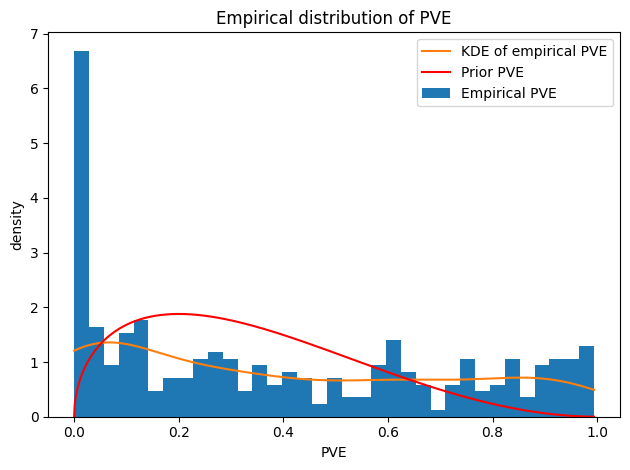

EPOCH 0: KL: 0.2604.
EPOCH 10: KL: 0.3065.
EPOCH 20: KL: 0.1620.
EPOCH 30: KL: 0.1496.
EPOCH 40: KL: 0.1233.
EPOCH 50: KL: 0.0928.
EPOCH 60: KL: 0.0941.
EPOCH 70: KL: 0.0412.
EPOCH 80: KL: 0.3099.
EPOCH 90: KL: -0.0090.
EPOCH 100: KL: 0.0821.
EPOCH 110: KL: 0.2090.
EPOCH 120: KL: -0.0654.
EPOCH 130: KL: -0.2574.
EPOCH 140: KL: 0.0507.
EPOCH 150: KL: 0.2925.
EPOCH 160: KL: -0.1328.
EPOCH 170: KL: 0.3932.
EPOCH 180: KL: 0.0965.
EPOCH 190: KL: 0.2901.


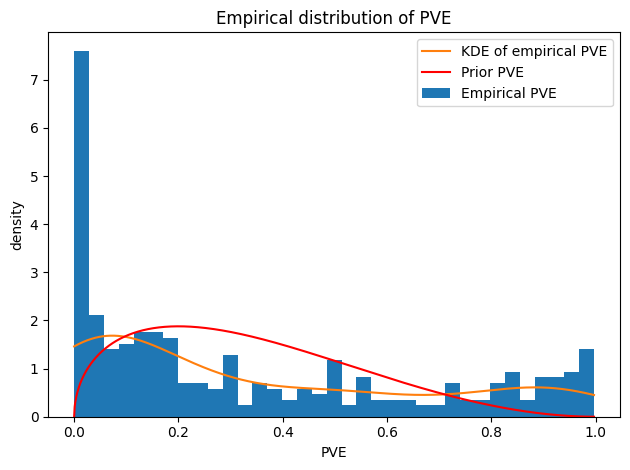

In [ ]:
start = time.time()
scale_concrete_noisy = learn_optimal_pve()
computing_time_learning_pve_concrete_noisy =  time.time() - start

In [ ]:
print('optimal scale is ' + str(scale_concrete_noisy))

optimal scale is [0.19758616]


## 2 - Statistical study

In [ ]:
num_simu = 10

list_test_error_hmf = []
list_test_error_ihmf = []
list_test_error_hmf_pve = []
list_test_error_ihmf_pve = []

list_time_hmf = []
list_time_ihmf = []
list_time_hmf_pve = []
list_time_ihmf_pve = []

beta_t = torch.from_numpy(scale_concrete_noisy); alpha_t = 2.; num_epoch = 5000

for i in range(num_simu):
  print("training IHMF + PVE - simu : ", i+1," / ", num_simu)
  start = time.time()
  ihmf_pve = Info_Hier_Meanfield_PVE_NN(num_feature, num_hidden_nodes, k_min, k_max, tau, alpha_s, beta_s, alpha_t, beta_t)
  training_error_ihmf_pve, test_error_ihmf_pve = training_nn(ihmf_pve, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)
  exe_time_ihmf_pve = time.time() - start
  list_time_ihmf_pve.append(exe_time_ihmf_pve)

  print("training HMF - simu : ", i+1," / ", num_simu)
  start = time.time()
  hmf = Hier_Meanfield_NN(num_feature, num_hidden_nodes, alpha_s, beta_s, alpha_s, beta_s)
  training_error_hmf, test_error_hmf = training_nn(hmf, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)
  exe_time_hmf = time.time() - start
  list_time_hmf.append(exe_time_hmf)

  print("training IHMF - simu : ", i+1," / ", num_simu)
  start = time.time()
  ihmf = Info_Hier_Meanfield_NN(num_feature, num_hidden_nodes, k_min, k_max, tau, alpha_s, beta_s, alpha_s, beta_s)
  training_error_ihmf, test_error_ihmf = training_nn(ihmf, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)
  exe_time_ihmf = time.time() - start
  list_time_ihmf.append(exe_time_ihmf)

  print("training HMF + PVE - simu : ", i+1," / ", num_simu)
  start = time.time()
  hmf_pve = Hier_Meanfield_PVE_NN(num_feature, num_hidden_nodes, alpha_s, beta_s, alpha_t, beta_t)
  training_error_hmf_pve, test_error_hmf_pve = training_nn(hmf_pve, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)
  exe_time_hmf_pve = time.time() - start
  list_time_hmf_pve.append(exe_time_hmf_pve)

  list_test_error_hmf.append(test_error_hmf[-1])
  list_test_error_ihmf.append(test_error_ihmf[-1])
  list_test_error_hmf_pve.append(test_error_hmf_pve[-1])
  list_test_error_ihmf_pve.append(test_error_ihmf_pve[-1])

  print("Resultats intermédiaire  : Concrete dataset avec bruit- simu : ", i+1," / ", num_simu)
  print("moyenne test error HMF", mean_list(list_test_error_hmf), " / temps d'exécution : ", mean_list(list_time_ihmf_pve))
  print("moyenne test error IHMF", mean_list(list_test_error_ihmf), " / temps d'exécution : ", mean_list(list_time_hmf))
  print("moyenne test error HMF + PVE", mean_list(list_test_error_hmf_pve), " / temps d'exécution : ", mean_list(list_time_ihmf) + computing_time_learning_pve_concrete_noisy)
  print("moyenne test error IHMF + PVE", mean_list(list_test_error_ihmf_pve), " / temps d'exécution : ", mean_list(list_time_hmf_pve) + computing_time_learning_pve_concrete_noisy)

print("Concrete dataset avec bruit")
print("moyenne test error HMF", mean_list(list_test_error_hmf), " / temps d'exécution : ", mean_list(list_time_ihmf_pve))
print("moyenne test error IHMF", mean_list(list_test_error_ihmf), " / temps d'exécution : ", mean_list(list_time_hmf))
print("moyenne test error HMF + PVE", mean_list(list_test_error_hmf_pve), " / temps d'exécution : ", mean_list(list_time_ihmf) + computing_time_learning_pve_concrete_noisy)
print("moyenne test error IHMF + PVE", mean_list(list_test_error_ihmf_pve), " / temps d'exécution : ", mean_list(list_time_hmf_pve) + computing_time_learning_pve_concrete_noisy))

training IHMF + PVE - simu :  1  /  10
EPOACH 1: TRAIN LOSS: 2.9953; KL REG: 19291.9121; TEST LOSS IS: 2.77578.
EPOACH 501: TRAIN LOSS: 1.0132; KL REG: 1573.3512; TEST LOSS IS: 1.06239.
EPOACH 1001: TRAIN LOSS: 1.0607; KL REG: 123.1629; TEST LOSS IS: 1.10326.
EPOACH 1501: TRAIN LOSS: 1.0585; KL REG: 67.3887; TEST LOSS IS: 1.09887.
EPOACH 2001: TRAIN LOSS: 1.0587; KL REG: 41.6278; TEST LOSS IS: 1.10021.
EPOACH 2501: TRAIN LOSS: 1.0584; KL REG: 47.4779; TEST LOSS IS: 1.09939.
EPOACH 3001: TRAIN LOSS: 1.0585; KL REG: 48.5879; TEST LOSS IS: 1.09966.
EPOACH 3501: TRAIN LOSS: 1.0585; KL REG: 37.7595; TEST LOSS IS: 1.09893.
EPOACH 4001: TRAIN LOSS: 1.0584; KL REG: 38.3566; TEST LOSS IS: 1.09901.
EPOACH 4501: TRAIN LOSS: 1.0584; KL REG: 47.7561; TEST LOSS IS: 1.09906.
training HMF - simu :  1  /  10
EPOACH 1: TRAIN LOSS: 3.1812; KL REG: 19423.7441; TEST LOSS IS: 3.68050.
EPOACH 501: TRAIN LOSS: 0.7990; KL REG: 2695.6082; TEST LOSS IS: 1.01162.
EPOACH 1001: TRAIN LOSS: 1.0070; KL REG: 1344.0162

TypeError: ignored

# Concrete / without noise

## 1 - Learning PVE

In [ ]:
path_data = os.getcwd() + '/InformativePrior/data/'
########### Training Hyperparameters
num_hidden_nodes = [50, 30]; alpha_s = 0.001; beta_s = 0.001
learning_rate = 2*1e-3
batch_size = 100
###########
num_random = 0; noise_level = 0.
## Load the data
x, y, x_test, y_test, num_useful, num_feature = data_generating_concrete(path_data, num_random, noise_level)
k_min = 0.; k_max = num_useful; tau = np.exp(2);


In [ ]:
def learn_optimal_pve():
    alpha_prior = 5; beta_prior = 1.2; prior = BetaPrior(alpha_prior, beta_prior)  # prior pve: Beta(1.5,3)
    eta = 0.1; estimator = SteinGradientEstimator(eta)  # define the stein gradient estimator
    learning_rate = 2 * 1e-3;  M = 300 # define learning rate and batch size (M)
    num_hidden_nodes = [50, 30] # define the NN architecture
    sampler = PVESampler_InfoARD(x, M, num_hidden_nodes, k_min, k_max, tau)  # define the sampler of implicity distribution
    samples = sampler()
    plot_empirical(samples, prior)
    parameters = sampler.parameters()
    optimizer = optim.SGD(parameters, lr=learning_rate)
    num_epoch_stein = 200;
    scale = minimize_kldivergence(sampler, prior, optimizer, estimator, num_epoch_stein)
    samples = sampler()
    plot_empirical(samples, prior)
    return scale

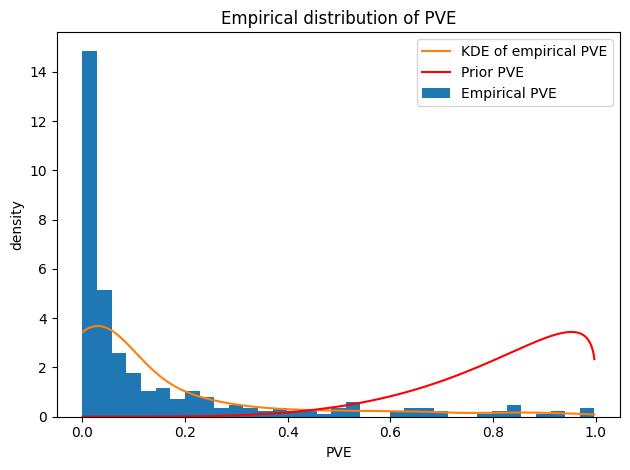

EPOCH 0: KL: 15.4289.
EPOCH 10: KL: 11.7279.
EPOCH 20: KL: 5.3378.
EPOCH 30: KL: 6.6969.
EPOCH 40: KL: 6.0090.
EPOCH 50: KL: 6.8328.
EPOCH 60: KL: 7.1320.
EPOCH 70: KL: 3.8263.
EPOCH 80: KL: 5.0725.
EPOCH 90: KL: 5.9231.
EPOCH 100: KL: 5.7563.
EPOCH 110: KL: 5.4876.
EPOCH 120: KL: 5.5333.
EPOCH 130: KL: 5.1004.
EPOCH 140: KL: 6.0608.
EPOCH 150: KL: 5.8708.
EPOCH 160: KL: 6.6692.
EPOCH 170: KL: 4.4465.
EPOCH 180: KL: 5.8281.
EPOCH 190: KL: 8.0699.


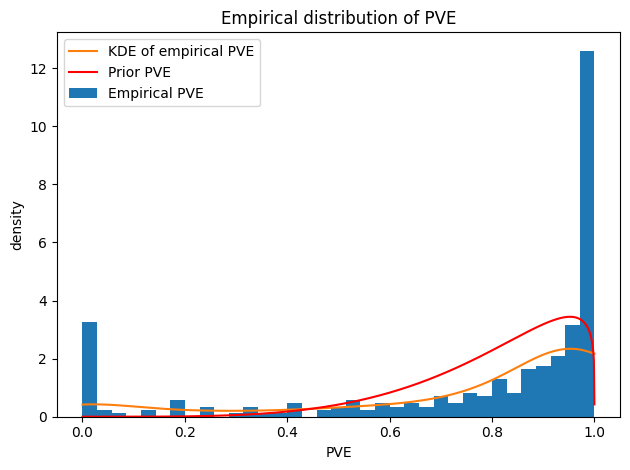

In [ ]:
start = time.time()
scale_concrete_no_noisy = learn_optimal_pve()
computing_time_learning_pve_concrete_no_noisy = time.time() - start

In [ ]:
print('optimal scale is ' + str(scale_concrete_no_noisy))

optimal scale is [0.47931165]


## 2 - Statistical study

In [ ]:
num_simu = 10

list_test_error_hmf = []
list_test_error_ihmf = []
list_test_error_hmf_pve = []
list_test_error_ihmf_pve = []

list_time_hmf = []
list_time_ihmf = []
list_time_hmf_pve = []
list_time_ihmf_pve = []

beta_t = torch.from_numpy(scale_concrete_no_noisy); alpha_t = 2.; num_epoch = 5000

for i in range(num_simu):
  print("training IHMF + PVE - simu : ", i+1," / ", num_simu)
  start = time.time()
  ihmf_pve = Info_Hier_Meanfield_PVE_NN(num_feature, num_hidden_nodes, k_min, k_max, tau, alpha_s, beta_s, alpha_t, beta_t)
  training_error_ihmf_pve, test_error_ihmf_pve = training_nn(ihmf_pve, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)
  exe_time_ihmf_pve = time.time() - start
  list_time_ihmf_pve.append(exe_time_ihmf_pve)

  print("training HMF - simu : ", i+1," / ", num_simu)
  start = time.time()
  hmf = Hier_Meanfield_NN(num_feature, num_hidden_nodes, alpha_s, beta_s, alpha_s, beta_s)
  training_error_hmf, test_error_hmf = training_nn(hmf, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)
  exe_time_hmf = time.time() - start
  list_time_hmf.append(exe_time_hmf)

  print("training IHMF - simu : ", i+1," / ", num_simu)
  start = time.time()
  ihmf = Info_Hier_Meanfield_NN(num_feature, num_hidden_nodes, k_min, k_max, tau, alpha_s, beta_s, alpha_s, beta_s)
  training_error_ihmf, test_error_ihmf = training_nn(ihmf, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)
  exe_time_ihmf = time.time() - start
  list_time_ihmf.append(exe_time_ihmf)

  print("training HMF + PVE - simu : ", i+1," / ", num_simu)
  start = time.time()
  hmf_pve = Hier_Meanfield_PVE_NN(num_feature, num_hidden_nodes, alpha_s, beta_s, alpha_t, beta_t)
  training_error_hmf_pve, test_error_hmf_pve = training_nn(hmf_pve, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)
  exe_time_hmf_pve = time.time() - start
  list_time_hmf_pve.append(exe_time_hmf_pve)

  list_test_error_hmf.append(test_error_hmf[-1])
  list_test_error_ihmf.append(test_error_ihmf[-1])
  list_test_error_hmf_pve.append(test_error_hmf_pve[-1])
  list_test_error_ihmf_pve.append(test_error_ihmf_pve[-1])

  print("Resultats intermédiaire  : Concrete dataset sans bruit- simu : ", i," / ", num_simu-1)
  print("moyenne test error HMF", mean_list(list_test_error_hmf), " / temps d'exécution : ", mean_list(list_time_ihmf_pve))
  print("moyenne test error IHMF", mean_list(list_test_error_ihmf), " / temps d'exécution : ", mean_list(list_time_hmf))
  print("moyenne test error HMF + PVE", mean_list(list_test_error_hmf_pve), " / temps d'exécution : ", mean_list(list_time_ihmf) + computing_time_learning_pve_concrete_no_noisy)
  print("moyenne test error IHMF + PVE", mean_list(list_test_error_ihmf_pve), " / temps d'exécution : ", mean_list(list_time_hmf_pve) + computing_time_learning_pve_concrete_no_noisy)

print("Concrete dataset sans bruit")
print("moyenne test error HMF", mean_list(list_test_error_hmf), " / temps d'exécution : ", mean_list(list_time_ihmf_pve))
print("moyenne test error IHMF", mean_list(list_test_error_ihmf), " / temps d'exécution : ", mean_list(list_time_hmf))
print("moyenne test error HMF + PVE", mean_list(list_test_error_hmf_pve), " / temps d'exécution : ", mean_list(list_time_ihmf) + computing_time_learning_pve_concrete_no_noisy)
print("moyenne test error IHMF + PVE", mean_list(list_test_error_ihmf_pve), " / temps d'exécution : ", mean_list(list_time_hmf_pve) + computing_time_learning_pve_concrete_no_noisy)

training IHMF + PVE - simu :  1  /  10
EPOACH 1: TRAIN LOSS: 0.7953; KL REG: 5409.3120; TEST LOSS IS: 0.95659.
EPOACH 501: TRAIN LOSS: 0.1662; KL REG: 931.4698; TEST LOSS IS: 0.18250.
EPOACH 1001: TRAIN LOSS: 0.1551; KL REG: 428.6367; TEST LOSS IS: 0.17300.
EPOACH 1501: TRAIN LOSS: 0.1376; KL REG: 371.5914; TEST LOSS IS: 0.15214.
EPOACH 2001: TRAIN LOSS: 0.1357; KL REG: 352.8530; TEST LOSS IS: 0.15687.
EPOACH 2501: TRAIN LOSS: 0.1346; KL REG: 341.8408; TEST LOSS IS: 0.15660.
EPOACH 3001: TRAIN LOSS: 0.1289; KL REG: 339.2955; TEST LOSS IS: 0.15472.
EPOACH 3501: TRAIN LOSS: 0.1277; KL REG: 340.0880; TEST LOSS IS: 0.14866.
EPOACH 4001: TRAIN LOSS: 0.1265; KL REG: 344.1004; TEST LOSS IS: 0.14975.
EPOACH 4501: TRAIN LOSS: 0.1256; KL REG: 342.6286; TEST LOSS IS: 0.14774.
training HMF - simu :  1  /  10
EPOACH 1: TRAIN LOSS: 1.6740; KL REG: 5886.1221; TEST LOSS IS: 2.10683.
EPOACH 501: TRAIN LOSS: 0.1357; KL REG: 1404.8612; TEST LOSS IS: 0.15850.
EPOACH 1001: TRAIN LOSS: 0.1232; KL REG: 957.3

# Yacht / without noise

## Learning PVE

In [ ]:
path_data = os.getcwd() + '/InformativePrior/data/'
########### Training Hyperparameters
num_hidden_nodes = [50, 30]; alpha_s = 0.001; beta_s = 0.001
learning_rate = 2*1e-3
batch_size = 100
###########
num_random = 0; noise_level = 0.
## Load the data
x, y, x_test, y_test, num_useful, num_feature = data_generating_yacht(path_data, num_random, noise_level)
k_min = 0.; k_max = num_useful; tau = np.exp(2);

      x1     x2    x3    x4    x5     x6     x7
0   -2.3  0.568  4.78  3.99  3.17  0.150   0.27
1   -2.3  0.568  4.78  3.99  3.17  0.175   0.47
2   -2.3  0.568  4.78  3.99  3.17  0.200   0.78
3   -2.3  0.568  4.78  3.99  3.17  0.225   1.18
4   -2.3  0.568  4.78  3.99  3.17  0.250   1.82
..   ...    ...   ...   ...   ...    ...    ...
302 -2.3  0.600  4.34  4.23  2.73  0.350   8.47
303 -2.3  0.600  4.34  4.23  2.73  0.375  12.27
304 -2.3  0.600  4.34  4.23  2.73  0.400  19.59
305 -2.3  0.600  4.34  4.23  2.73  0.425  30.48
306 -2.3  0.600  4.34  4.23  2.73  0.450  46.66

[307 rows x 7 columns] Index(['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7'], dtype='object')


In [ ]:
def learn_optimal_pve():
    alpha_prior = 5; beta_prior = 1.2; prior = BetaPrior(alpha_prior, beta_prior)  # prior pve: Beta(1.5,3)
    eta = 0.1; estimator = SteinGradientEstimator(eta)  # define the stein gradient estimator
    learning_rate = 2 * 1e-3;  M = 300 # define learning rate and batch size (M)
    num_hidden_nodes = [50, 30] # define the NN architecture
    sampler = PVESampler_InfoARD(x, M, num_hidden_nodes, k_min, k_max, tau)  # define the sampler of implicity distribution
    samples = sampler()
    plot_empirical(samples, prior)
    parameters = sampler.parameters()
    optimizer = optim.SGD(parameters, lr=learning_rate)
    num_epoch_stein = 200;
    scale = minimize_kldivergence(sampler, prior, optimizer, estimator, num_epoch_stein)
    samples = sampler()
    plot_empirical(samples, prior)
    return scale

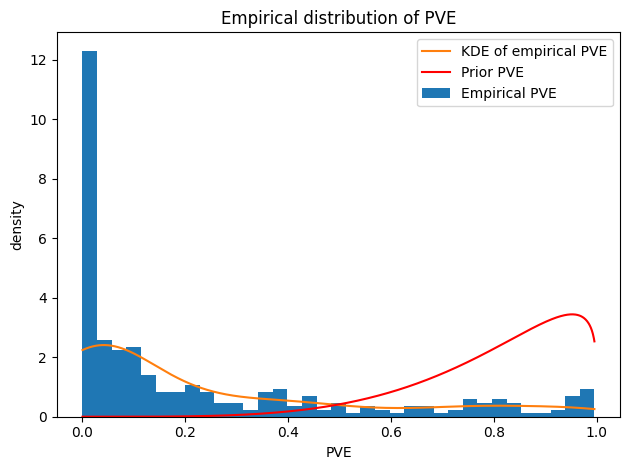

EPOCH 0: KL: 13.3118.
EPOCH 10: KL: 10.0444.
EPOCH 20: KL: 9.2472.
EPOCH 30: KL: 9.0288.
EPOCH 40: KL: 7.6368.
EPOCH 50: KL: 8.6931.
EPOCH 60: KL: 9.5488.
EPOCH 70: KL: 7.1047.
EPOCH 80: KL: 9.5553.
EPOCH 90: KL: 7.2403.
EPOCH 100: KL: 6.9296.
EPOCH 110: KL: 8.4501.
EPOCH 120: KL: 8.4629.
EPOCH 130: KL: 8.0806.
EPOCH 140: KL: 6.4948.
EPOCH 150: KL: 6.2255.
EPOCH 160: KL: 11.2746.
EPOCH 170: KL: 7.7117.
EPOCH 180: KL: 8.0691.
EPOCH 190: KL: 4.9958.


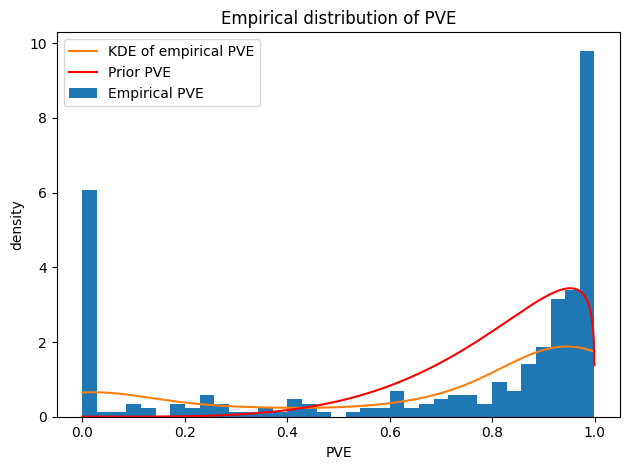

In [ ]:
start = time.time()
scale_yacht_no_noisy = learn_optimal_pve()
computing_time_learning_pve_yacht_no_noisy = time.time() - start

In [ ]:
print('optimal scale is ' + str(scale_yacht_no_noisy))

optimal scale is [0.505081]


## Statistical study

In [ ]:
num_simu = 10

list_test_error_hmf = []
list_test_error_ihmf = []
list_test_error_hmf_pve = []
list_test_error_ihmf_pve = []

list_time_hmf = []
list_time_ihmf = []
list_time_hmf_pve = []
list_time_ihmf_pve = []

beta_t = torch.from_numpy(scale_yacht_no_noisy); alpha_t = 2.; num_epoch = 5000

for i in range(num_simu):
  print("training IHMF + PVE - simu : ", i+1," / ", num_simu)
  start = time.time()
  ihmf_pve = Info_Hier_Meanfield_PVE_NN(num_feature, num_hidden_nodes, k_min, k_max, tau, alpha_s, beta_s, alpha_t, beta_t)
  training_error_ihmf_pve, test_error_ihmf_pve = training_nn(ihmf_pve, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)
  exe_time_ihmf_pve = time.time() - start
  list_time_ihmf_pve.append(exe_time_ihmf_pve)

  print("training HMF - simu : ", i+1," / ", num_simu)
  start = time.time()
  hmf = Hier_Meanfield_NN(num_feature, num_hidden_nodes, alpha_s, beta_s, alpha_s, beta_s)
  training_error_hmf, test_error_hmf = training_nn(hmf, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)
  exe_time_hmf = time.time() - start
  list_time_hmf.append(exe_time_hmf)

  print("training IHMF - simu : ", i+1," / ", num_simu)
  start = time.time()
  ihmf = Info_Hier_Meanfield_NN(num_feature, num_hidden_nodes, k_min, k_max, tau, alpha_s, beta_s, alpha_s, beta_s)
  training_error_ihmf, test_error_ihmf = training_nn(ihmf, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)
  exe_time_ihmf = time.time() - start
  list_time_ihmf.append(exe_time_ihmf)

  print("training HMF + PVE - simu : ", i+1," / ", num_simu)
  start = time.time()
  hmf_pve = Hier_Meanfield_PVE_NN(num_feature, num_hidden_nodes, alpha_s, beta_s, alpha_t, beta_t)
  training_error_hmf_pve, test_error_hmf_pve = training_nn(hmf_pve, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)
  exe_time_hmf_pve = time.time() - start
  list_time_hmf_pve.append(exe_time_hmf_pve)

  list_test_error_hmf.append(test_error_hmf[-1])
  list_test_error_ihmf.append(test_error_ihmf[-1])
  list_test_error_hmf_pve.append(test_error_hmf_pve[-1])
  list_test_error_ihmf_pve.append(test_error_ihmf_pve[-1])
  
  print("Resultats intermédiaire  : Yacht dataset sans bruit- simu : ", i," / ", num_simu-1)
  print("moyenne test error HMF", mean_list(list_test_error_hmf), " / temps d'exécution : ", mean_list(list_time_ihmf_pve))
  print("moyenne test error IHMF", mean_list(list_test_error_ihmf), " / temps d'exécution : ", mean_list(list_time_hmf))
  print("moyenne test error HMF + PVE", mean_list(list_test_error_hmf_pve), " / temps d'exécution : ", mean_list(list_time_ihmf) + computing_time_learning_pve_yacht_no_noisy)
  print("moyenne test error IHMF + PVE", mean_list(list_test_error_ihmf_pve), " / temps d'exécution : ", mean_list(list_time_hmf_pve) + computing_time_learning_pve_yacht_no_noisy)

print("Yacht dataset sans bruit")
print("moyenne test error HMF", mean_list(list_test_error_hmf), " / temps d'exécution : ", mean_list(list_time_ihmf_pve))
print("moyenne test error IHMF", mean_list(list_test_error_ihmf), " / temps d'exécution : ", mean_list(list_time_hmf))
print("moyenne test error HMF + PVE", mean_list(list_test_error_hmf_pve), " / temps d'exécution : ", mean_list(list_time_ihmf) + computing_time_learning_pve_yacht_no_noisy)
print("moyenne test error IHMF + PVE", mean_list(list_test_error_ihmf_pve), " / temps d'exécution : ", mean_list(list_time_hmf_pve) + computing_time_learning_pve_yacht_no_noisy)

training IHMF + PVE - simu :  1  /  10
EPOACH 1: TRAIN LOSS: 0.9751; KL REG: 5146.1875; TEST LOSS IS: 1.09413.
EPOACH 501: TRAIN LOSS: 0.0310; KL REG: 2512.3999; TEST LOSS IS: 0.04822.
EPOACH 1001: TRAIN LOSS: 0.0496; KL REG: 919.3015; TEST LOSS IS: 0.06572.
EPOACH 1501: TRAIN LOSS: 0.0276; KL REG: 416.9163; TEST LOSS IS: 0.03758.
EPOACH 2001: TRAIN LOSS: 0.0478; KL REG: 296.6790; TEST LOSS IS: 0.06136.
EPOACH 2501: TRAIN LOSS: 0.0423; KL REG: 250.4313; TEST LOSS IS: 0.05754.
EPOACH 3001: TRAIN LOSS: 0.0265; KL REG: 228.9539; TEST LOSS IS: 0.03658.
EPOACH 3501: TRAIN LOSS: 0.0293; KL REG: 214.8233; TEST LOSS IS: 0.03986.
EPOACH 4001: TRAIN LOSS: 0.0225; KL REG: 205.8702; TEST LOSS IS: 0.03013.
EPOACH 4501: TRAIN LOSS: 0.0274; KL REG: 197.3833; TEST LOSS IS: 0.03893.
training HMF - simu :  1  /  10
EPOACH 1: TRAIN LOSS: 61.4862; KL REG: 5608.1465; TEST LOSS IS: 57.80561.
EPOACH 501: TRAIN LOSS: 0.1889; KL REG: 3447.0820; TEST LOSS IS: 0.24833.
EPOACH 1001: TRAIN LOSS: 0.1406; KL REG: 16

# Yacht / with noise

## Learning PVE

In [ ]:
path_data = os.getcwd() + '/InformativePrior/data/'
########### Training Hyperparameters
num_hidden_nodes = [50, 30]; alpha_s = 0.001; beta_s = 0.001
learning_rate = 2*1e-3
batch_size = 100
###########
num_random = 100; noise_level = 0.8
## Load the data
x, y, x_test, y_test, num_useful, num_feature = data_generating_yacht(path_data, num_random, noise_level)
k_min = 0.; k_max = num_useful; tau = np.exp(2);

      x1     x2    x3    x4    x5     x6     x7
0   -2.3  0.568  4.78  3.99  3.17  0.150   0.27
1   -2.3  0.568  4.78  3.99  3.17  0.175   0.47
2   -2.3  0.568  4.78  3.99  3.17  0.200   0.78
3   -2.3  0.568  4.78  3.99  3.17  0.225   1.18
4   -2.3  0.568  4.78  3.99  3.17  0.250   1.82
..   ...    ...   ...   ...   ...    ...    ...
302 -2.3  0.600  4.34  4.23  2.73  0.350   8.47
303 -2.3  0.600  4.34  4.23  2.73  0.375  12.27
304 -2.3  0.600  4.34  4.23  2.73  0.400  19.59
305 -2.3  0.600  4.34  4.23  2.73  0.425  30.48
306 -2.3  0.600  4.34  4.23  2.73  0.450  46.66

[307 rows x 7 columns] Index(['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7'], dtype='object')


In [ ]:
def learn_optimal_pve():
    alpha_prior = 1.5; beta_prior = 3; prior = BetaPrior(alpha_prior, beta_prior)  # prior pve: Beta(1.5,3)
    eta = 0.1; estimator = SteinGradientEstimator(eta)  # define the stein gradient estimator
    learning_rate = 2 * 1e-3;  M = 300 # define learning rate and batch size (M)
    num_hidden_nodes = [50, 30] # define the NN architecture
    sampler = PVESampler_InfoARD(x, M, num_hidden_nodes, k_min, k_max, tau)  # define the sampler of implicity distribution
    samples = sampler()
    plot_empirical(samples, prior)
    parameters = sampler.parameters()
    optimizer = optim.SGD(parameters, lr=learning_rate)
    num_epoch_stein = 200;
    scale = minimize_kldivergence(sampler, prior, optimizer, estimator, num_epoch_stein)
    samples = sampler()
    plot_empirical(samples, prior)
    return scale

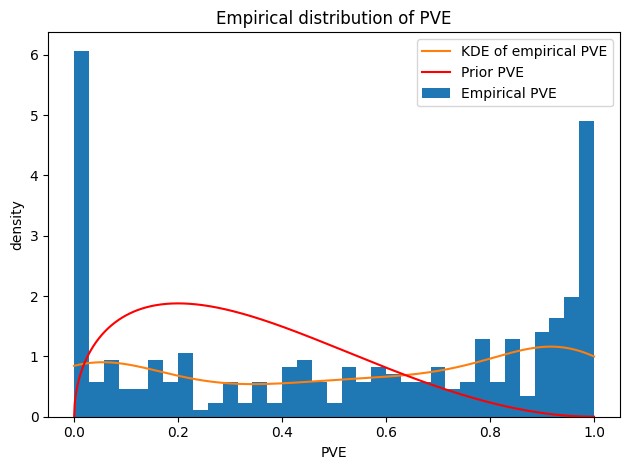

EPOCH 0: KL: 1.6357.
EPOCH 10: KL: 1.1744.
EPOCH 20: KL: 0.6502.
EPOCH 30: KL: 0.6330.
EPOCH 40: KL: 0.6497.
EPOCH 50: KL: 0.7464.
EPOCH 60: KL: 0.3428.
EPOCH 70: KL: 0.4718.
EPOCH 80: KL: 0.3021.
EPOCH 90: KL: 0.5008.
EPOCH 100: KL: 0.5623.
EPOCH 110: KL: 0.3311.
EPOCH 120: KL: 0.5971.
EPOCH 130: KL: 0.2825.
EPOCH 140: KL: 0.4527.
EPOCH 150: KL: 0.6037.
EPOCH 160: KL: 0.3225.
EPOCH 170: KL: 0.1479.
EPOCH 180: KL: 0.4872.
EPOCH 190: KL: 0.2962.


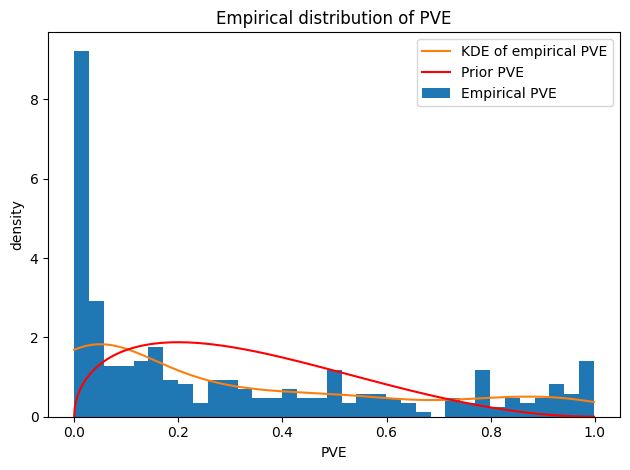

In [ ]:
start = time.time()
scale_yacht_noisy = learn_optimal_pve()
computing_time_learning_pve_yacht_noisy = time.time() - start

In [ ]:
print('optimal scale is ' + str(scale_yacht_noisy))

optimal scale is [0.21847454]


## Statistical study

In [ ]:
num_simu = 10

list_test_error_hmf = []
list_test_error_ihmf = []
list_test_error_hmf_pve = []
list_test_error_ihmf_pve = []

list_time_hmf = []
list_time_ihmf = []
list_time_hmf_pve = []
list_time_ihmf_pve = []

beta_t = torch.from_numpy(scale_yacht_noisy); alpha_t = 2.; num_epoch = 5000

for i in range(num_simu):
  print("training IHMF + PVE - simu : ", i+1," / ", num_simu)
  start = time.time()
  ihmf_pve = Info_Hier_Meanfield_PVE_NN(num_feature, num_hidden_nodes, k_min, k_max, tau, alpha_s, beta_s, alpha_t, beta_t)
  training_error_ihmf_pve, test_error_ihmf_pve = training_nn(ihmf_pve, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)
  exe_time_ihmf_pve = time.time() - start
  list_time_ihmf_pve.append(exe_time_ihmf_pve)

  print("training HMF - simu : ", i+1," / ", num_simu)
  start = time.time()
  hmf = Hier_Meanfield_NN(num_feature, num_hidden_nodes, alpha_s, beta_s, alpha_s, beta_s)
  training_error_hmf, test_error_hmf = training_nn(hmf, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)
  exe_time_hmf = time.time() - start
  list_time_hmf.append(exe_time_hmf)

  print("training IHMF - simu : ", i+1," / ", num_simu)
  start = time.time()
  ihmf = Info_Hier_Meanfield_NN(num_feature, num_hidden_nodes, k_min, k_max, tau, alpha_s, beta_s, alpha_s, beta_s)
  training_error_ihmf, test_error_ihmf = training_nn(ihmf, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)
  exe_time_ihmf = time.time() - start
  list_time_ihmf.append(exe_time_ihmf)

  print("training HMF + PVE - simu : ", i+1," / ", num_simu)
  start = time.time()
  hmf_pve = Hier_Meanfield_PVE_NN(num_feature, num_hidden_nodes, alpha_s, beta_s, alpha_t, beta_t)
  training_error_hmf_pve, test_error_hmf_pve = training_nn(hmf_pve, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)
  exe_time_hmf_pve = time.time() - start
  list_time_hmf_pve.append(exe_time_hmf_pve)

  list_test_error_hmf.append(test_error_hmf[-1])
  list_test_error_ihmf.append(test_error_ihmf[-1])
  list_test_error_hmf_pve.append(test_error_hmf_pve[-1])
  list_test_error_ihmf_pve.append(test_error_ihmf_pve[-1])

  print("Resultats intermédiaire  : Yacht dataset avec bruit- simu : ", i+1," / ", num_simu)
  print("moyenne test error HMF", mean_list(list_test_error_hmf), " / temps d'exécution : ", mean_list(list_time_ihmf_pve))
  print("moyenne test error IHMF", mean_list(list_test_error_ihmf), " / temps d'exécution : ", mean_list(list_time_hmf))
  print("moyenne test error HMF + PVE", mean_list(list_test_error_hmf_pve), " / temps d'exécution : ", mean_list(list_time_ihmf) + computing_time_learning_pve_yacht_noisy)
  print("moyenne test error IHMF + PVE", mean_list(list_test_error_ihmf_pve), " / temps d'exécution : ", mean_list(list_time_hmf_pve) + computing_time_learning_pve_yacht_noisy)

print("Resultats finaux : Yacht dataset avec bruit")
print("moyenne test error HMF", mean_list(list_test_error_hmf), " / temps d'exécution : ", mean_list(list_time_ihmf_pve))
print("moyenne test error IHMF", mean_list(list_test_error_ihmf), " / temps d'exécution : ", mean_list(list_time_hmf))
print("moyenne test error HMF + PVE", mean_list(list_test_error_hmf_pve), " / temps d'exécution : ", mean_list(list_time_ihmf) + computing_time_learning_pve_yacht_noisy)
print("moyenne test error IHMF + PVE", mean_list(list_test_error_ihmf_pve), " / temps d'exécution : ", mean_list(list_time_hmf_pve) + computing_time_learning_pve_yacht_noisy)

training IHMF + PVE - simu :  1  /  10
EPOACH 1: TRAIN LOSS: 4.0073; KL REG: 19221.5645; TEST LOSS IS: 3.65050.
EPOACH 501: TRAIN LOSS: 0.3538; KL REG: 9409.7422; TEST LOSS IS: 1.04523.
EPOACH 1001: TRAIN LOSS: 0.8580; KL REG: 2768.3677; TEST LOSS IS: 0.96744.
EPOACH 1501: TRAIN LOSS: 0.9694; KL REG: 619.6041; TEST LOSS IS: 0.97684.
EPOACH 2001: TRAIN LOSS: 1.0559; KL REG: 306.2943; TEST LOSS IS: 1.00648.
EPOACH 2501: TRAIN LOSS: 1.0612; KL REG: 179.3810; TEST LOSS IS: 1.01671.
EPOACH 3001: TRAIN LOSS: 1.1191; KL REG: 186.1029; TEST LOSS IS: 1.03570.
EPOACH 3501: TRAIN LOSS: 1.1189; KL REG: 125.4108; TEST LOSS IS: 1.04306.
EPOACH 4001: TRAIN LOSS: 1.1325; KL REG: 102.9342; TEST LOSS IS: 1.05262.
EPOACH 4501: TRAIN LOSS: 1.1339; KL REG: 71.9669; TEST LOSS IS: 1.06027.
training HMF - simu :  1  /  10
EPOACH 1: TRAIN LOSS: 7.5179; KL REG: 19138.9082; TEST LOSS IS: 7.91726.
EPOACH 501: TRAIN LOSS: 0.3842; KL REG: 10379.4902; TEST LOSS IS: 1.14191.
EPOACH 1001: TRAIN LOSS: 0.6588; KL REG: 3

# Comments


no justification:
*   of the Beta(5,1.2) law for the original datassets and the Beta(1.5,3) law for the extended datasets for the optimization of the beta hyper-parameter,
*   of the IG(0.001,0.001) for non informative priors about PVE,
*   why, for the informative prior for the PVE learning, to do the reparametrization trick, we fix alpha to 2

